In [1]:
import os
import json
import gzip
import time
import random

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from tqdm import tqdm

In [2]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[0], device_type='GPU')
tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

In [3]:
DATA_PATH = '../data/phone_data.json.gz'
RANDOM_SEED = 0

In [4]:
%matplotlib inline

In [5]:
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # tf 2.0+
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

### Load data

In [6]:
def gzip2json(path):
    with gzip.GzipFile(path, 'r') as fin:
        data = json.loads(fin.read().decode('utf-8'))
    return data

In [7]:
data = gzip2json(DATA_PATH)

* chr(769) we are replacing stress near letters
* adding a for cases word transcription missed it, for such word like *-тися -> *-тись etc.

TODO: think about removing dash '-' as it has no phoneme at all

In [8]:
words, letters, phones = [], [], []
ignored = 0

for item in tqdm(data):
    word = item['word'].lower()
    ltrs = [letter for letter in word]
    phns = [letter.replace(chr(769), '') for letter in item['phones']]
    
    if set(['#', "{и^е}'", "{о^у}'", "о'", "ґ'"]).intersection(phns):
        ignored += 1
        continue
    
    words.append(word)
    letters.append(ltrs)
    phones.append(phns)

data_preprocessed = list(zip(words, letters, phones))

100%|██████████| 160385/160385 [00:01<00:00, 147351.07it/s]


In [9]:
print('ignored:', ignored)

ignored: 80


In [10]:
sample = random.choice(data_preprocessed)
print(f'word: ', sample[0])
print(f'letters: ', sample[1])
print(f'phonemes: ', sample[2])

word:  перепрошений
letters:  ['п', 'е', 'р', 'е', 'п', 'р', 'о', 'ш', 'е', 'н', 'и', 'й']
phonemes:  ['п', '{е^и}', 'р', '{е^и}', 'п', 'р', 'о', 'ш', '{е^и}', 'н', 'и', 'й']


### Preprocess

In [18]:
from sklearn.model_selection import train_test_split

In [20]:
def flatten(array):
    for item in array:
        if isinstance(item, list):
            yield from flatten(item)
        else:
            yield item

In [202]:
class SequenceTokenizer:
    
    def __init__(self):
        self.vocab = {}
        self.inverse_vocab = {}
        
    def fit(self, sequence):
        self.index2word = dict(enumerate(sorted(set(flatten(sequence)))))
        self.word2index = {v:k for k,v in self.index2word.items()}
        return self
    
    def transform(self, X):
        res = []
        for line in X:
            res.append([self.word2index[item] for item in line])
        return res

In [227]:
input_sequences = letters
target_sequences = phones

#### lstm data

In [228]:
# input_sequences = [['<start>'] + item + ['<end>'] for item in input_sequences]
target_sequences = [['<start>'] + item + ['<end>'] for item in target_sequences]

In [229]:
letter_tokenizer = SequenceTokenizer().fit(input_sequences)
phone_tokenizer = SequenceTokenizer().fit(target_sequences)

In [230]:
# remove '<start>' and '<end>' for lstm training
# input_sequences = [item[1:-1] for item in input_sequences]

In [231]:
unique_letters = sorted(set(flatten(input_sequences)))
unique_phones = sorted(set(flatten(target_sequences)))

In [232]:
num_encoder_tokens = len(unique_letters)
num_decoder_tokens = len(unique_phones)
max_encoder_seq_length = max([len(item) for item in input_sequences])
max_decoder_seq_length = max([len(item) for item in target_sequences])

In [233]:
print('Number of samples:', len(input_sequences))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 160305
Number of unique input tokens: 35
Number of unique output tokens: 94
Max sequence length for inputs: 33
Max sequence length for outputs: 33


In [243]:
# X = letter_tokenizer.transform(input_sequences)
# y = phone_tokenizer.transform(target_sequences)

In [242]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=RANDOM_SEED)

In [236]:
# X_train

In [237]:
encoder_input_data = np.zeros(
    (len(input_sequences), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_sequences), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_sequences), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [238]:
X, y = [], []

for i, (input_sequence, target_sequence) in enumerate(zip(input_sequences, target_sequences)):
    _ = []
    for t, char in enumerate(input_sequence):
        encoder_input_data[i, t, letter_tokenizer.word2index[char]] = 1.
        _.append(letter_tokenizer.word2index[char]])
    for t, char in enumerate(target_sequence):
        decoder_input_data[i, t, phone_tokenizer.word2index[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, phone_tokenizer.word2index[char]] = 1.

In [245]:
X[0]

[2, 2, 23, 7, 15]

In [174]:
# embedding_dim = 64
# latent_dim = 128

# encoder_inputs = tf.keras.layers.Input(shape=(None, max_encoder_seq_length + 1))
# encoder_emb = tf.keras.layers.Embedding(input_dim=num_encoder_tokens, output_dim=embedding_dim)(encoder_inputs)
# encoder = tf.keras.layers.LSTM(latent_dim, return_state=True)
# encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# encoder_states = [state_h, state_c]

# decoder_inputs = tf.keras.layers.Input(shape=(None, max_decoder_seq_length + 1))
# decoder_emb = tf.keras.layers.Embedding(input_dim=num_decoder_tokens, output_dim=embedding_dim)(decoder_inputs)
# decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
# decoder_outputs, _, _ = decoder_lstm(decoder_emb, initial_state=encoder_states)

# decoder_dense = tf.keras.layers.Dense(num_decoder_tokens, activation='softmax')
# decoder_outputs = decoder_dense(decoder_outputs)

# model = tf.keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs, name='seq2seq_lstm')

In [ ]:
# pool2_flat = tf.reshape(pool2, [-1, 24 * 24 * 64])

In [135]:
# sorted(set(flatten(X)))

In [136]:
tmp = [tf.keras.utils.to_categorical(item, num_classes=num_encoder_tokens) for item in X]

In [ ]:
tf

In [148]:
tmp[0].shape

(7, 37)

In [145]:
np.vstack(tmp).shape

(1919815, 37)

In [14]:
max_len_encoder = max(map(lambda x: len(x), letters))
max_len_decoder = max(map(lambda x: len(x), phones))
unique_phones = set(flatten(phones))
print(max_len_encoder, max_len_decoder)

33 31


In [15]:
tokenizer = SequenceTokenizer().fit(letters+phones)

In [16]:
X = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.transform(letters), padding='post')
y = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.transform(phones), padding='post')

In [17]:
# X = np.expand_dims(X, axis=1)
# y = np.expand_dims(y, axis=1)

In [18]:
X.shape, y.shape

((160305, 33), (160305, 31))

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=RANDOM_SEED)

In [20]:
X_train.shape, y_train.shape

((144274, 33), (144274, 31))

### Seq2seq LSTM

In [21]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.

In [23]:
input_sequences = letters
target_sequences = phones

In [24]:
target_sequences = [['<start>'] + item + ['<end>'] for item in target_sequences]

In [25]:
unique_letters = sorted(set(flatten(input_sequences)))
# unique_letters

In [26]:
unique_phones = sorted(set(flatten(target_sequences)))
# unique_phones

In [27]:
num_encoder_tokens = len(unique_letters)
num_decoder_tokens = len(unique_phones)
max_encoder_seq_length = max([len(item) for item in input_sequences])
max_decoder_seq_length = max([len(item) for item in target_sequences])

In [28]:
print('Number of samples:', len(input_sequences))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 160305
Number of unique input tokens: 35
Number of unique output tokens: 94
Max sequence length for inputs: 33
Max sequence length for outputs: 33


In [29]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(unique_letters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(unique_phones)])

In [30]:
encoder_input_data = np.zeros(
    (len(input_sequences), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_sequences), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_sequences), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [250]:
var1, var2, var3, var4 = train_test_split(list(zip(encoder_input_data, decoder_input_data)), decoder_target_data)

In [257]:
var1[0][0].shape

(33, 35)

In [31]:
for i, (input_sequence, target_sequence) in enumerate(zip(input_sequences, target_sequences)):
    for t, char in enumerate(input_sequence):
        encoder_input_data[i, t, letter_tokenizer.inverse_vocab[char]] = 1.
    for t, char in enumerate(target_sequence):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [44]:
encoder_inputs = tf.keras.layers.Input(shape=(None, num_encoder_tokens))
encoder = tf.keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = tf.keras.layers.Input(shape=(None, num_decoder_tokens))
decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

decoder_dense = tf.keras.layers.Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = tf.keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs, name='seq2seq_lstm')

In [45]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.2, verbose=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7, min_delta=1e-3, verbose=True), 
    tf.keras.callbacks.ModelCheckpoint(filepath='seq2seq_lstm.h5', save_best_only=True, verbose=True)
]

model.summary()

Model: "seq2seq_lstm"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, 35)]   0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None, 94)]   0                                            
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 256), (None, 299008      input_5[0][0]                    
__________________________________________________________________________________________________
lstm_5 (LSTM)                   [(None, None, 256),  359424      input_6[0][0]                    
                                                                 lstm_4[0][1]          

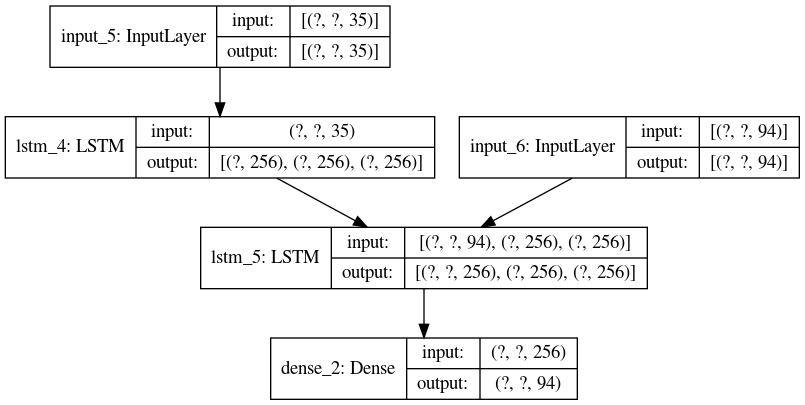

In [46]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [47]:
history = model.fit(
    [encoder_input_data, decoder_input_data], decoder_target_data,
    batch_size=batch_size,
    epochs=100,
    callbacks=callbacks,
    validation_split=0.1
)

Train on 144274 samples, validate on 16031 samples
Epoch 1/100
144256/144274 [============================>.] - ETA: 0s - loss: 0.7146 - accuracy: 0.7507
Epoch 00001: val_loss improved from inf to 0.76312, saving model to seq2seq_lstm.h5
144274/144274 [==============================] - 19s 134us/sample - loss: 0.7145 - accuracy: 0.7507 - val_loss: 0.7631 - val_accuracy: 0.8171
Epoch 2/100
144000/144274 [============================>.] - ETA: 0s - loss: 0.4318 - accuracy: 0.8744
Epoch 00002: val_loss improved from 0.76312 to 0.55943, saving model to seq2seq_lstm.h5
144274/144274 [==============================] - 15s 107us/sample - loss: 0.4316 - accuracy: 0.8745 - val_loss: 0.5594 - val_accuracy: 0.8704
Epoch 3/100
144000/144274 [============================>.] - ETA: 0s - loss: 0.2312 - accuracy: 0.9310
Epoch 00003: val_loss improved from 0.55943 to 0.46950, saving model to seq2seq_lstm.h5
144274/144274 [==============================] - 16s 108us/sample - loss: 0.2311 - accuracy: 0.9

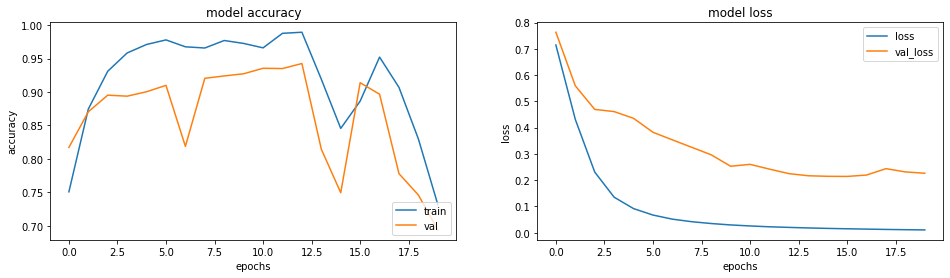

In [50]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['loss', 'val_loss'], loc='upper right')

plt.show()

In [52]:
model = tf.keras.models.load_model('seq2seq_lstm.h5')

In [56]:
encoder_inputs = model.input[0]   # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output   # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]   # input_2
decoder_state_input_h = tf.keras.layers.Input(shape=(latent_dim,), name='input_3')
decoder_state_input_c = tf.keras.layers.Input(shape=(latent_dim,), name='input_4')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = tf.keras.models.Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [57]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [66]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['<start>']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = []
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += [sampled_char]

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '<end>' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence[:-1]

In [67]:
seq_index = 123

input_seq = encoder_input_data[seq_index: seq_index + 1]
decoded_sentence = decode_sequence(input_seq)
print('-')
print('Input sentence:', input_sequences[seq_index])
print('Decoded sentence:', decoded_sentence)

-
Input sentence: ['а', 'б', 'р', 'а', 'м', 'о', 'в', 'и', 'ч']
Decoded sentence: ['а', 'б', 'р', 'а', 'м', 'о', 'в', '{и^е}', 'ч']


In [ ]:
# from __future__ import print_function

# from keras.models import Model
# from keras.layers import Input, LSTM, Dense
# import numpy as np

# batch_size = 64  # Batch size for training.
# epochs = 100  # Number of epochs to train for.
# latent_dim = 256  # Latent dimensionality of the encoding space.
# num_samples = 10000  # Number of samples to train on.
# # Path to the data txt file on disk.
# data_path = 'fra-eng/fra.txt'

# # Vectorize the data.
# input_texts = []
# target_texts = []
# input_characters = set()
# target_characters = set()
# with open(data_path, 'r', encoding='utf-8') as f:
#     lines = f.read().split('\n')
# for line in lines[: min(num_samples, len(lines) - 1)]:
#     input_text, target_text = line.split('\t')
#     # We use "tab" as the "start sequence" character
#     # for the targets, and "\n" as "end sequence" character.
#     target_text = '\t' + target_text + '\n'
#     input_texts.append(input_text)
#     target_texts.append(target_text)
#     for char in input_text:
#         if char not in input_characters:
#             input_characters.add(char)
#     for char in target_text:
#         if char not in target_characters:
#             target_characters.add(char)

# input_characters = sorted(list(input_characters))
# target_characters = sorted(list(target_characters))
# num_encoder_tokens = len(input_characters)
# num_decoder_tokens = len(target_characters)
# max_encoder_seq_length = max([len(txt) for txt in input_texts])
# max_decoder_seq_length = max([len(txt) for txt in target_texts])

# print('Number of samples:', len(input_texts))
# print('Number of unique input tokens:', num_encoder_tokens)
# print('Number of unique output tokens:', num_decoder_tokens)
# print('Max sequence length for inputs:', max_encoder_seq_length)
# print('Max sequence length for outputs:', max_decoder_seq_length)

# input_token_index = dict(
#     [(char, i) for i, char in enumerate(input_characters)])
# target_token_index = dict(
#     [(char, i) for i, char in enumerate(target_characters)])

# encoder_input_data = np.zeros(
#     (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
#     dtype='float32')
# decoder_input_data = np.zeros(
#     (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
#     dtype='float32')
# decoder_target_data = np.zeros(
#     (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
#     dtype='float32')

# for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
#     for t, char in enumerate(input_text):
#         encoder_input_data[i, t, input_token_index[char]] = 1.
#     encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
#     for t, char in enumerate(target_text):
#         # decoder_target_data is ahead of decoder_input_data by one timestep
#         decoder_input_data[i, t, target_token_index[char]] = 1.
#         if t > 0:
#             # decoder_target_data will be ahead by one timestep
#             # and will not include the start character.
#             decoder_target_data[i, t - 1, target_token_index[char]] = 1.
#     decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
#     decoder_target_data[i, t:, target_token_index[' ']] = 1.
# Define an input sequence and process it.
# encoder_inputs = Input(shape=(None, num_encoder_tokens))
# encoder = LSTM(latent_dim, return_state=True)
# encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# # We discard `encoder_outputs` and only keep the states.
# encoder_states = [state_h, state_c]

# # Set up the decoder, using `encoder_states` as initial state.
# decoder_inputs = Input(shape=(None, num_decoder_tokens))
# # We set up our decoder to return full output sequences,
# # and to return internal states as well. We don't use the
# # return states in the training model, but we will use them in inference.
# decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
# decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
#                                      initial_state=encoder_states)
# decoder_dense = Dense(num_decoder_tokens, activation='softmax')
# decoder_outputs = decoder_dense(decoder_outputs)

# # Define the model that will turn
# # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
# model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

In [ ]:
encoder_inputs = tf.keras.layers.Input(shape=(None, max_len_encoder))

encoder = tf.keras.layers.LSTM(128, return_state=True)

encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

In [ ]:
decoder_inputs = tf.keras.layers.Input(shape=(None, max_len_decoder))

decoder_lstm = tf.keras.layers.LSTM(128, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

decoder_dense = tf.keras.layers.Dense(len(unique_phones), activation='softmax')

decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
model = tf.keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.2, verbose=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=5, min_delta=1e-3, verbose=True), 
    tf.keras.callbacks.ModelCheckpoint(filepath='g2p_lstm.h5', save_best_only=True, verbose=True)
]

model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# history = model.fit(x=[X, y], y=y,
# #                     class_weight='balanced',
#                     epochs=2,
#                     batch_size=32,
#                     callbacks=callbacks,
# #                     validation_data=([X_dev, y_dev], y_dev),
#                     verbose=1)

### Seq2seq with Attention

In [246]:
train_input, test_input, train_output, test_output = X_train, X_test, y_train, y_test

In [247]:
BUFFER_SIZE = train_input.shape[0]
BUFFER_SIZE_VAL = test_input.shape[0]
BATCH_SIZE = 128
steps_per_epoch = BUFFER_SIZE // BATCH_SIZE
steps_per_epoch_val = BUFFER_SIZE_VAL // BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_size = len(tokenizer.vocab) + 1

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
max_length_input, max_length_output = train_input.shape[1], train_output.shape[1]

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_output)).shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_output)).shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_output_batch = next(iter(train_dataset))
example_input_batch.shape, example_output_batch.shape

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)

        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)

        x = self.embedding(x)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        output, state = self.gru(x)

        output = tf.reshape(output, (-1, output.shape[2]))

        x = self.fc(output)

        return x, state, attention_weights

In [ ]:
encoder = Encoder(vocab_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

In [ ]:
decoder = Decoder(vocab_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

In [ ]:
optimizer = tf.keras.optimizers.Adam()

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
@tf.function
def train_step(inp, out, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([tokenizer.vocab['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the output as the next input
        for t in range(1, out.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(out[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(out[:, t], 1)

    batch_loss = (loss / int(out.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [ ]:
@tf.function
def val_step(inp, out, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([tokenizer.vocab['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the output as the next input
        for t in range(1, out.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(out[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(out[:, t], 1)

    batch_loss = (loss / int(out.shape[1]))

    return batch_loss

In [ ]:
n_epochs = 30
history = {}

for epoch in range(1, n_epochs+1):
    start_time = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    total_val_loss = 0
    
    print(f"Epoch {epoch}/{n_epochs}")
    
    for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

    for (batch, (inp, targ)) in enumerate(test_dataset.take(steps_per_epoch)):
        batch_loss = val_step(inp, targ, enc_hidden)
        total_val_loss += batch_loss
    
    print('loss: {loss:.4f}\tval_loss: {val_loss:.4f}\texec_time: {exec_time:.2f} seconds\n'.format(
            loss = total_loss / steps_per_epoch, 
            val_loss = total_val_loss / steps_per_epoch_val,
            exec_time = time.time() - start_time))
    
    history['train'] = history.get('train', []) + [total_loss.numpy() / steps_per_epoch]
    history['val'] = history.get('val', []) + [total_val_loss.numpy() / steps_per_epoch_val]
            
#     saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

In [ ]:
plt.plot(history['train'])
plt.plot(history['val'])
plt.title('model loss')
plt.ylabel('val')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
def evaluate(word):
    
    ltrs = [letter for letter in word]
    if ltrs[0] != '<start>':
        ltrs = ['<start>'] + ltrs
    if ltrs[-1] != '<end>':
        ltrs = ltrs + ['<end>']
    
    attention_plot = np.zeros((max_length_output, max_length_input))

    inputs = tokenizer.transform([ltrs])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=max_length_input,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([tokenizer.vocab['<start>']], 0)

    for t in range(max_length_output):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += tokenizer.inverse_vocab[predicted_id] + ' '

        if tokenizer.inverse_vocab[predicted_id] == '<end>':
            return result, " ".join(ltrs), attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)
        
    return result, " ".join(ltrs), attention_plot

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    

def paraphrase(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted paraphrase: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
evaluate('аахен')[0].replace('<end>', '').split()

In [ ]:
paraphrase('автівка')

In [ ]:
y_pred = []

for item in tqdm(data_preprocessed[:1000]):
    prediction = evaluate(item[0])[0].replace('<end>', '').strip()
    true = " ".join(item[2][1:-1])
    y_pred.append((true, prediction, int(prediction==true)))
#     y_pred.append(evaluate(item[0])[0].replace('<end>', '').strip())
#     y_test.append(" ".join(item[2][1:-1]))

In [ ]:
true_pred = [item[:2] for item in y_pred if item[2] == 1]
false_pred = [item[:2] for item in y_pred if item[2] == 0]
accuracy = len(true_pred) / len(y_pred)
accuracy

In [ ]:
# true_pred